# Lecture 1 - Multiple Comparisons

## High-Level Goals of this Course

- Distinguish between **experimentally-generated data** and **observational data**, with particular reference to the strength of ensuing statistical conclusions regarding **causality**.
- Fit and interpret regression models for observational data, with particular reference to adjustment for potential **confounding variables**.
- Apply the principle of “*block what you can, randomize what you cannot*” in designing an **A/B testing experiments**.

## Firstly, let us make a block overview!

- **Lecture 1:** Multiple comparisons and false discovery (*“Can I believe in science?”*).
- **Lecture 2:** Confounding, randomized versus non-randomized studies (*“Okay, it’s not so bad...”*).
- **Lectures 3-5:** Randomized study issues (*“Okay, it’s even better than I thought...”*).
- **Lectures 6-8:** Non-randomized study issues (*“It’s hopeless!”*).

In this course, there will be few new statistical tools to pick up. But we will need (and perhaps hone) our regression skills!

Again, this course is entirely taught in `R` with a reasonable mathematical and statistical basis. There will be eight lectures and four labs. We strongly recommend reviewing the following **frequentist** courses:

- [**DSCI 551: Descriptive Statistics and Probability for Data Science**](https://github.com/UBC-MDS/DSCI_551_stat-prob-dsci) for basic statistical and probabilistic concepts, and familiarity with the mathematical notation
- [**DSCI 552 - Statistical Inference and Computation I**](https://github.com/UBC-MDS/DSCI_552_stat-inf-1) for statistical inference concepts with a frequentist approach.
- [**DSCI 561 - Regression I**](https://github.com/UBC-MDS/DSCI_561_regr-1) for ordinary least-squares (OLS)
- [**DSCI 562 - Regression II**](https://ubc-mds.github.io/DSCI_562_regr-2/README.html) for more advanced regression models.

```{attention}
Keep in mind the following: this is a **concepts block**.
```

## What is the Relevance of this Course to Data Science?

### Indirect Relevance

This course is an inherent part of your statistical training **given your current statistical maturity**. You already learned a comprehensive set of statistical tools in the previous courses.

Moreover, we will stress the concept of "**joined-up thinking**" on the entire data pipeline:

- How data are **collected**.
- How data are **analyzed**.
- How conclusions are **drawn**.
- The strength of the **resulting story** (i.e., how robust the data story-telling is).

```{important}
This "**joined-up thinking**" is related to the [**Data Science Workflow**](https://ubc-mds.github.io/DSCI_562_regr-2/notes/lecture1-glm-link-functions-and-count-regression.html#data-science-workflow) from **DSCI 562 - Regression II**.
```

### Direct Relevance

Throughout the block, we will review the following two major classes of statistical studies to adress **causality**:

- **Randomized studies:** In this class of studies, the researcher can **randomly** allocate the subjects to one of the experimental treatments. An **experimental treatment** is a given testing strategy (e.g., in pharmaceutical trials, a **placebo** is a **control treatment** whereas the **experimental drug** is the **treatment of interest**). Specifically, in Data Science, we could encounter the example below.

```{admonition} Example
:class: hint
A/B testing for website optimization:

- *Does a tweak to a website improve user experience and/or generate more sales?* (i.e., control **website A** versus experimental **website B**).
 - *Can we end a test early?* This is called **early-stopping** in statistical jargon.
```

- **Non-randomized studies:** In many different case studies, treatment randomization is impossible. Hence, we need to apply certain statistical concepts and tools to address our specific inquiries.

```{admonition} Example
:class: hint
Pharmaco-epidemiology problems and electronic health records:

- We might encounter different data pipelines for massive healthcare utilization databases to obtain knowledge about drug efficacy and safety.
```

## Today's Learning Objectives

1. Review frequentist hypothesis testing.
2. Examine the misuse of $p$-values in scientific literature.
3. Demonstrate the misuse of $p$-values via a simulation.
4. Explain the macro-properties of carrying out many hypothesis tests in the context of a single dataset.
5. Use Bonferroni and False Discovery Rate correction to alter the macro-properties when conducting many hypothesis tests.
6. Contrast the Bonferroni correction with the False Discovery Rate.

## Loading `R` Packages

In [1]:
options(repr.matrix.max.rows = 8, repr.matrix.max.cols = 7)
library(mvtnorm)
library(ggplot2)
library(reshape2)
library(tidyverse)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## 1. Hypothesis Testing Review

In statistical inference, we have **two hypotheses**: the **null** $H_0$ and the **alternative** $H_a$. 

$H_0$ represents the status quo in our case study, whereas $H_a$ represents our hypothesis of interest. Furthermore, recall there are two types of errors shown in the table below.

|  |  **$H_0$ is true** |  **$H_0$ is not true** |
|:--------------------------------------------------------------------------------------------:|:------------------:|:----------------------:|
|                                   **Fail to reject $H_0$**                                   |       Correct (**TRUE NEGATIVE**)     |      Type II Error (**FALSE NEGATIVE**)     |
|                                       **Reject $H_0$**                                       |    Type I Error (**FALSE POSITIVE**)    |         Correct (**TRUE POSITIVE**)        |

These errors are I (**false positive**) and II (**false negative**). Their setup is targeted towards rejecting or not rejecting $H_0$, given that $H_0$ is true or not. Moreover, these errors are measured in **probabilities**.

The **frequentist hypothesis testing process** is the following:

1. We need to set up a pre-specified significance level (usually $\alpha = 0.05$). The significance level $\alpha$ will be our tolerance to type I error: **rejecting the null hypothesis when in fact is true**. 
2. Compute a **test statistic** from our sampled data. This test statistic will have a **sampling distribution** under $H_0$.
3. Compare the test statistic against **a certain quantile threshold under $H_0$**, then:

    - Reject $H_0$ in favour of $H_a$ if the test statistic **exceeds** this quantile threshold under $H_0$.
    - Do not reject $H_0$ otherwise.

```{attention} 
The quantile threshold is chosen such that 

$$P(\text{reject null} \mid \text{null is true}) = \alpha.$$
```

### 1.1. $p$-value

An **alternative way** of performing **Step 3** is computing the $p$-value associated to the test statistic under $H_0$.

Let us start with some mathematical notation. For this **Step 3**, **in general** let the test statistic be $T$ (**note the random variable notation as an uppercase!**) and the quantile threshold $c_\alpha$. Thus, we would reject $H_0$ if

$$T \geq c_\alpha.$$

Now, for our **observed** data, the test statistic will be $t_{\text{obs}}$ (**note the lowercase notation!**). In probability notation, the $p$-value can be represented as:

$$p\text{-value} = P\left(T \geq t_{obs} \mid \mbox{null is true}\right).$$

```{attention}
The $p$-value is the chance of getting a test statistic as or more extreme than what you actually got as **observed data**, presuming $H_0$ is true. **We will reject $H_0$ if**

$$p\text{-value} < \alpha.$$
```

### 1.2. Graphical Overview of the Hypothesis Testing

All the previous process can also be put as in the diagram below.

```{figure} ../img/classical-test-framework.png
:height: 300px
:name: classical_hypothesis_b

Workflow of a theory-based hypothesis testing.
```

### 1.3. Testing Procedure in a Nutshell

Let us start with some coding. The significance level $\alpha = 0.05$ testing procedure can be cast as:

- Reject $H_0$ if $p\text{-value} < \alpha = 0.05$.
- Do not reject $H_0$ otherwise.

This process can be coded as in the function below.

In [2]:
hypothesis.test <- function(alpha = 0.05, p_value) {
  reject <- (p_value < alpha)
  return(reject)
}

## 2. Hypothesis Testing in Science

It is well known that it is easier to publish your work in a better journal if you have one (or more!) **statistically significant findings** at the (conventional) $\alpha = 0.05$ level.

### 2.1. Why does that happen?

This is in the function of what the scientific community considers as **"interesting results"**:

- By construction, the **null hypothesis** is "conservative"/"boring"/"status quo."
- The **alternative hypothesis** is usually more interesting than the null hypothesis, e.g., eating chocolate and living longer *are* associated.  **So a $p\text{-value} < 0.05$ is exciting!**

### 2.2. When $p\text{-value} > 0.05$

We have to make a controversial statement: **obtaining $p\text{-value} > 0.05$ is ambiguous!**

**Why are we stating that?** Here are some reasons:

- Data did not provide strong evidence **against** the null hypothesis.
- Maybe our test has **low power**.

Therefore, the New York Times (for instance) is **not** putting that in the Science section. For instance, **THESE HEADLINES WILL NEVER HAPPEN**:

- "*Scientists conclude that they do not have enough data.*"
- "*Null hypothesis not rejected.*"

### 2.3. An Journal Example on Statistical Significant Results

We often see reports of small $p$-values in abstracts of scientific papers. This is an example:

```{figure} ../img/screencapture-nejm2.png
:height: 300px
:name: screencapture_nejm2
```

```{figure} ../img/screencapture-nejm1.png
:height: 300px
:name: screencapture_nejm1
```

## 3. An Inconvenient Truth

It seems that this **standard scientific practice** of rejecting the null hypothesis $H_0$ when the $p\text{-value} < 0.05$ is a good one. Nevertheless, **carrying out many comparisons (tests)** in a single dataset but then only mentioning those that produce $p\text{-value} < 0.05$ is cheating!

We discussed this matter in **DSCI 552** and is called $p$-hacking:

> *We have to avoid a practice known as $p$-hacking in which we perform many different tests on our data to obtain any significant result to publish. By doing this, multiple testing occurs, which inflates our type I error if we do not control it with some available correction (e.g., Bonferroni correction).*

Keep in mind one important concept here: **Bonferroni correction**. It will be critical in this lecture.

### 3.1. Our First Simulation

Throughout the course, we will run different simulations to make key **proofs of concept**. We will start with the **inflation of the type I error**. Hence, let us run a **simulation** in three steps.

#### Step 1: Setting our 400 random alternative hypotheses

Suppose I want to test $20 \times 20$ food-health associations (i.e., 400 hypothesis testings based on 400 regression models **on a single dataset**).

In [3]:
# 20 food and health variables
nvars <- 20
# Food and human body parts
foods <- c(
  "Peanuts", "Dark Chocolate", "Wine", "Grass", "Cinnamon",
  "Ice Cream", "Potatoes", "Doritos", "Salsa", "Bugs",
  "Soap", "Yogurt", "Gatorade", "Milk Chocolate", "Raisins",
  "Cured Meat", "Raw Fish", "Dirt", "Toothpaste", "Apples"
)
health <- c(
  "heart", "lung", "gut", "cognitive", "foot",
  "arm", "eye", "hair", "dental", "ear",
  "knee", "hip", "fingernail", "joint", "shoulder",
  "muscle", "eyelash", "kidney", "skin", "mental"
)
# Class of association
outcome <- c("good","bad")

Once we have our possible variables and outcomes, let us build our 400 alternative hypotheses. We will do this randomly for `outcome`.

In [4]:
set.seed(554)
# Grid of all possible pairs
experiments <- expand.grid(foods, health)
names(experiments)[1:2] <- c("food", "health")
# The random outcomes associated to our 400 alternative hypothesis!
experiments$outcome <- outcome[sample.int(2, nvars * nvars, replace = TRUE)]
experiments

food,health,outcome
<fct>,<fct>,<chr>
Peanuts,heart,good
Dark Chocolate,heart,bad
Wine,heart,bad
Grass,heart,bad
⋮,⋮,⋮
Raw Fish,mental,bad
Dirt,mental,good
Toothpaste,mental,bad
Apples,mental,bad


Then, we build our 400 alternative hypotheses.

In [5]:
alternative_hypotheses <- paste("Eating ", tolower(experiments$food),
  " is ", experiments$outcome,
  " for ", experiments$health, " health.",
  sep = ""
)
as.data.frame(alternative_hypotheses)

alternative_hypotheses
<chr>
Eating peanuts is good for heart health.
Eating dark chocolate is bad for heart health.
Eating wine is bad for heart health.
Eating grass is bad for heart health.
⋮
Eating raw fish is bad for mental health.
Eating dirt is good for mental health.
Eating toothpaste is bad for mental health.
Eating apples is bad for mental health.


#### Step 2: Generating our Simulated Dataset

It is time to generate **our simulated dataset** to test our 400 alternative hypotheses. This dataset will be comprised of 20 **continuous** $X$ variables (**regressors**) and 20 $Y$ **continuous** variables (**responses**) measured on each of $n = 500$ people. Therefore:

  - $X$ variables are a person's intake of different foods.
  - $Y$ variables are different measures of a person's health.

We will need to use a made-up function `simulate_p()` to run our simulation. This simulation will include 400 simple regression models and record their corresponding $p$-values to assess the statistical association between each $X$ and $Y$. Note, we will generate our random data so that **none of the $X$ variables are associated with any of the $Y$ variables (i.e., $H_0$ is in fact true!)**. Each one of the 400 generic null hypotheses is set up as:

```{math}
\begin{gather*}
H_0 \text{: } X \text{ and } Y \text{are not linearly associated.} \\
H_a \text{: } \text{otherwise.}
\end{gather*}
```

```{attention}
Below is the `R` code to generate the random numbers in function `simulate_p()`. Reviewing this code is out of the scope of this lecture since it involves **Multivariate Normal concepts**. **As optional practice**, feel free to go through this code (you will find some useful comments on the way).
```

In [6]:
simulate_p <- function(nvars, nobs, rho) {
  sigmas_sq <- (1 - rho) * diag(nvars) # We assign the same variance to all nvars 
    # (main diagonal in an nvar times nvar variance-covariance matrix)
  if (nvars > 1) { # Now, we assign the same pairwise covariances in 
      # the nvar times nvar variance-covariance matrix 
      # (SO ANY VARIABLE WILL NOT STAND OUT AS STATISTICALLY SIGNIFICANT!)
    sigmas_sq <- sigmas_sq + rho * matrix(1, nvars, nvars)
  } 
  x <- rmvnorm( # We generate nobs times nvar multivariate normal random numbers (regressors) 
      # with vector mean of zeros and variance-covariance matrix sigmas_sq
    n = nobs, mean = rep(0, nvars),
    sigma = sigmas_sq
  )
  y <- rmvnorm( # We generate nobs times nvar multivariate normal random numbers (responses) 
      # with vector mean of zeros and variance-covariance matrix sigmas_sq
    n = nobs, mean = rep(0, nvars),
    sigma = sigmas_sq
  )

  # Finallly, we run nvar times nvar simple linear regressions of each X versus each Y
  # Then, we record the p-value from our lm() summaries
  pmat <- matrix(NA, nvars, nvars)
  for (i in 1:nvars) {
    for (j in 1:nvars) {
      pmat[i, j] <- anova(lm(y[, i] ~ x[, j]))$Pr[1]
    }
  }
  return(pmat) # pmat is the nvar x nvar matrix of p-values
}

#### Step 3: Running the 400 Regression Models

Then, we run all 400 regressions of one of the $Y$'s on one of the $X$'s.

In [7]:
sig_alpha <- 0.05 # alpha threshold
nvars <- 20
nobs <- 500
rho <- 0.75 # Variance-covariance matrix parameter denoting the same pairwise covariance for all the nvars, i.e.,
# the same status quo

set.seed(12345) # Global reproducibility
pval <- simulate_p(nvars, nobs, rho)

### 3.2. Checking our Simulation Results

We will check how many $p$-values are below `sig_alpha` in `pval` (i.e., **how many times we committed type I error**). 

**162 pairwise comparisons, out of 400 (i.e., 40.5%), are rejecting $H_0$ when in fact is true!**

In [8]:
sum(pval < sig_alpha)

[1] 162

In [9]:
options(repr.plot.height = 8, repr.plot.width = 14)

p.val.hist <- pval %>%
  melt() %>%
  ggplot(aes(x = value)) +
  geom_histogram(binwidth = 0.025, aes(y = after_stat(count)), colour = "black", fill = "gray") +
  geom_vline(aes(xintercept = sig_alpha), color = "blue", linetype = "dashed", linewidth = 1) +
  xlab("p-values") +
  theme(
    plot.title = element_text(size = 18, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18),
    legend.position = "none"
  ) +
  ggtitle("Histogram of Relative Frequencies of p-values Coming from 400 Simple Regression Models")

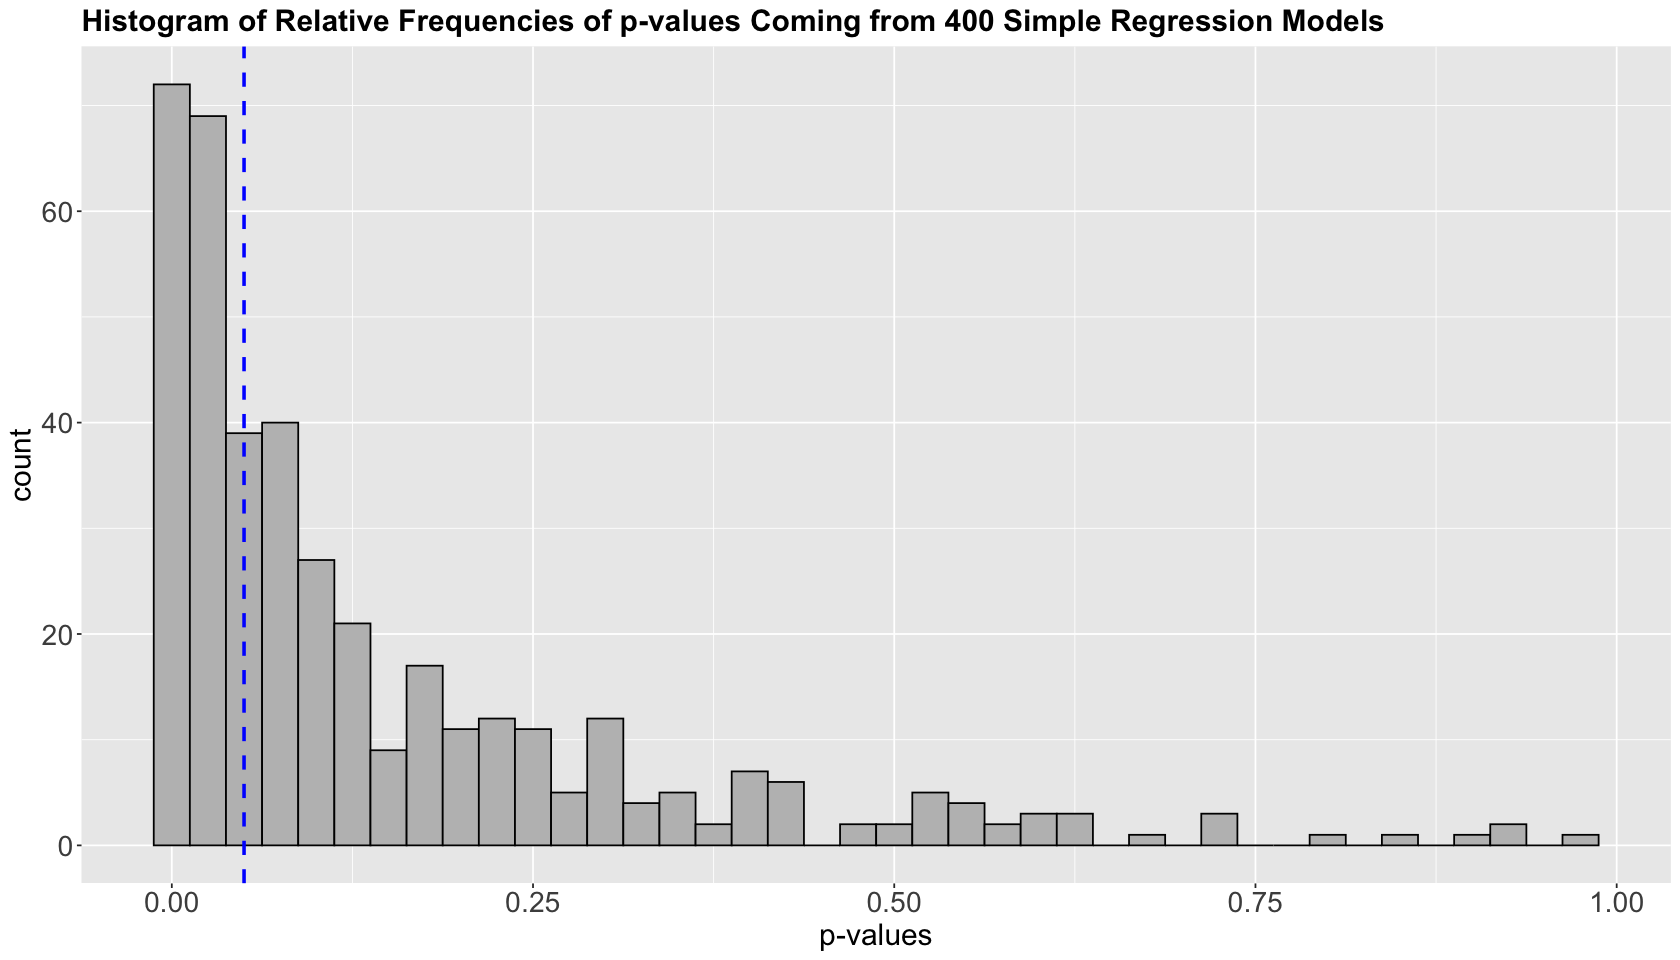

In [10]:
p.val.hist

The histogram above plots the $p$-values on the $x$-axis as counts on the $y$ axis. The vertical dashed blue line indicates the $\alpha$ threshold.

Imagine the $p$-values in the matrix `pval` correspond to the alternative hypotheses we constructed in `alternative_hypotheses`. Therefore, we can publish 162 papers, each generating a headline:

In [11]:
melt_p <- melt(pval) # Melting matrix pval before filtering those spurious significant results
melt_p

Var1,Var2,value
<int>,<int>,<dbl>
1,1,0.01144746
2,1,0.02435357
3,1,0.03857421
4,1,0.54722977
⋮,⋮,⋮
17,20,0.08290290
18,20,0.16151143
19,20,0.07920598
20,20,0.40985565


In [12]:
# Now, we filter those spurious significant results and their corresponding alternative hypotheses
print(alternative_hypotheses[melt_p$value < sig_alpha])

  [1] "Eating peanuts is good for heart health."           
  [2] "Eating dark chocolate is bad for heart health."     
  [3] "Eating wine is bad for heart health."               
  [4] "Eating bugs is good for heart health."              
  [5] "Eating peanuts is good for lung health."            
  [6] "Eating dark chocolate is good for lung health."     
  [7] "Eating wine is good for lung health."               
  [8] "Eating bugs is good for lung health."               
  [9] "Eating dark chocolate is bad for gut health."       
 [10] "Eating wine is good for gut health."                
 [11] "Eating bugs is good for gut health."                
 [12] "Eating toothpaste is bad for gut health."           
 [13] "Eating wine is good for cognitive health."          
 [14] "Eating peanuts is good for foot health."            
 [15] "Eating dark chocolate is bad for foot health."      
 [16] "Eating wine is bad for foot health."                
 [17] "Eating cinnamon is bad for foot h

**But this does not make any sense! We would be publishing misleading and non-sense results!**

```{exercise}
:label: lecture1-q1

Why are we seeing so many spurious statistically significant comparisons here?

**A.** We are inflating our Type I error.

**B.** We are inflating our Type II error.

**C.** We are inflating both Types of error: I and II.
```

```{exercise}
:label: lecture1-q2

How might we address this problem of so many spurious statistically significant comparisons?

**A.** Let us increase our power $1 - \beta$.

**B.** Let us decrease our significance level $\alpha$.

**C.** Let us decrease our significance level $\alpha$ and increase our power $1 - \beta$.
```

### 3.3. What is going on in our previous simulation?

Suppose we run $m$ **independent** tests on the same dataset. Each $i$th test $(i = 1, \dots m)$ has the following probability of committing **Type I error**:

```{math}
\begin{gather*}
E_ i = \text{Committing Type I error in the } i \text{th test} \\
P(E_ i) = \alpha.
\end{gather*}
```

The probability of **NOT committing Type I error** in the $i$th test is the following:

$$P\left(E_ i^c\right) = 1 - \alpha.$$

The **probability of NOT committing Type I error in ALL the $m$ tests** is an **intersection** of complements:

```{math}
\begin{align*}
P\left(E_{1}^c \cap E_{2}^c \cap \dots \cap E_{m}^c \right) &=  P\left(E_{1}^c\right) \times P\left(E_{2}^c\right) \times \dots \times P\left(E_{m}^c\right)\\
& = (1 - \alpha)^m \qquad \qquad \text{by indepedence.}
\end{align*}
```

Finally, the **probability of committing AT LEAST one Type I error in the $m$ tests** is the complement of the previous intersection:

$$P\left[ \left( E_{1}^c \cap E_{2}^c \cap \dots \cap E_{m}^c \right)^c \right] = 1 - (1 - \alpha)^m.$$

The inflated probability corresponds to committing AT LEAST one Type I error in the $m$ tests. We can plot this **theoretical behaviour** by varying $m$ on the $x$-axis as follows:

In [13]:
x <- 1:400
df <- data.frame(x)
alpha <- 0.05

inflated_error_plot <- ggplot(df, aes(x)) +
  xlim(0, 400) +
  geom_function(fun = function(x) 1 - (1 - alpha)^x, colour = "red") +
  theme(
    plot.title = element_text(size = 22),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
  ) +
  ggtitle(expression("Probability of Committing at LEAST one Type I error in the m tests with" ~ alpha ~ "= 0.05")) +
  xlab("m tests") +
  ylab("Probability") +
  scale_x_continuous(breaks = seq(0, 400, 25)) +
  scale_y_continuous(breaks = seq(0, 1, 0.1))

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


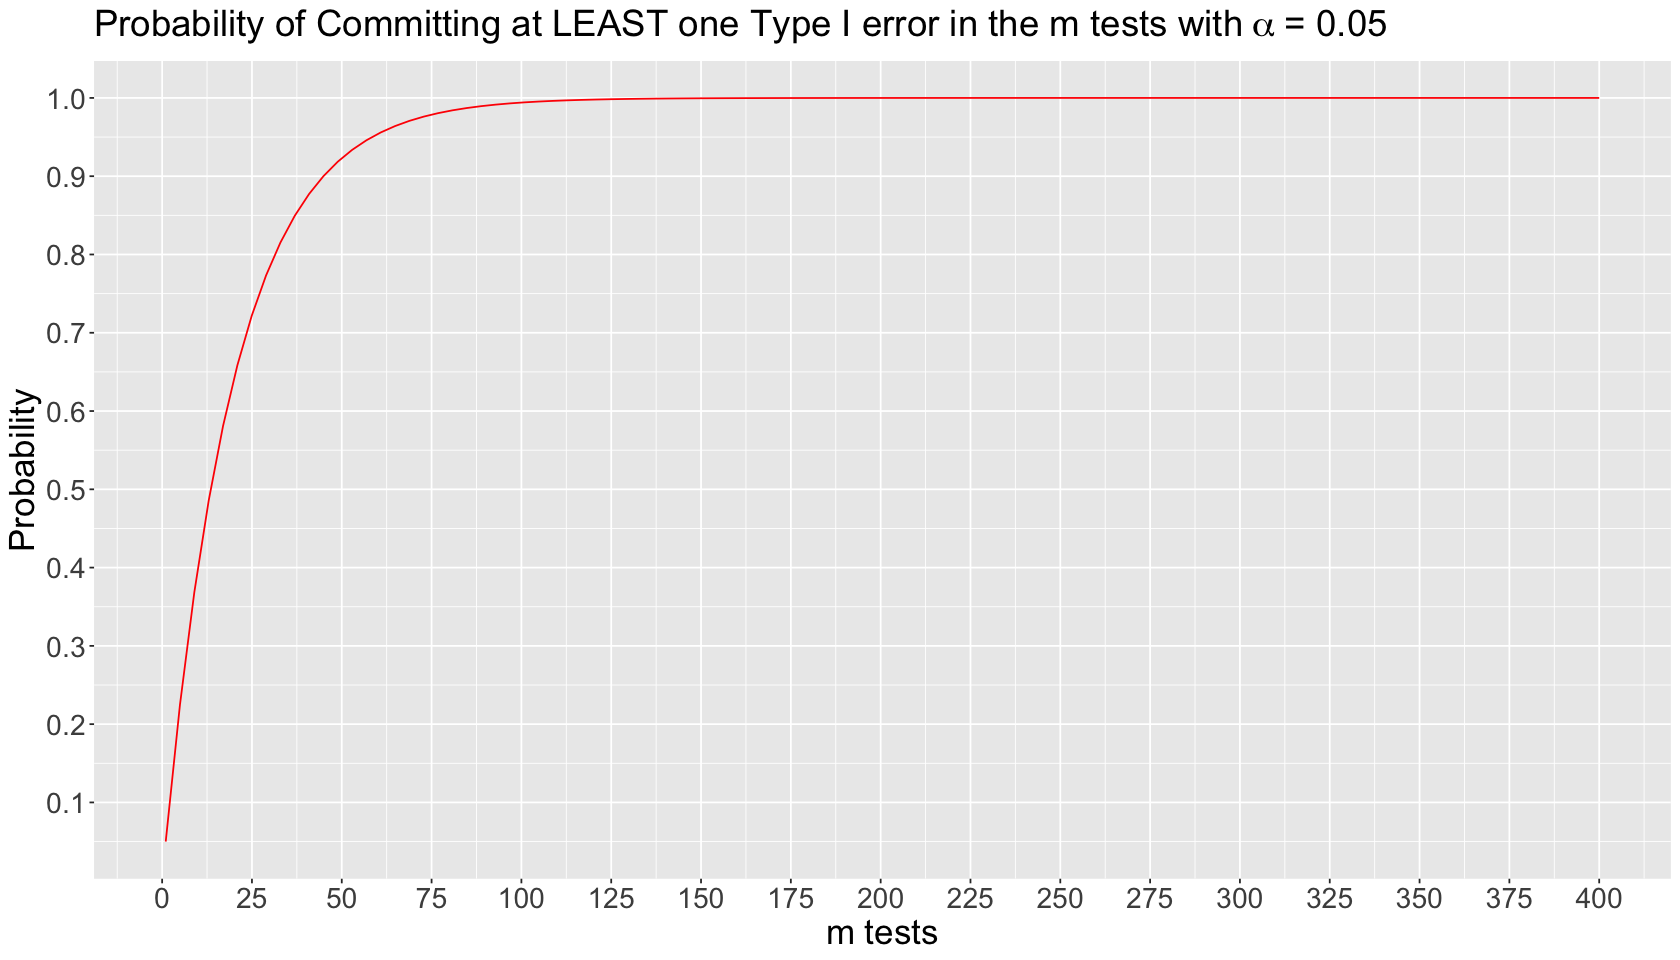

In [14]:
inflated_error_plot

## 4. The Bonferroni Correction

The Bonferroni correction **conservatively** guards against $p$-hacking! The idea is simple: 

> If $m$ comparisons (hypothesis tests) are to be carried out, use significance level $\alpha/m$ for each.

Let us go back to our simulation with $m = 20 \times 20 = 400$ comparisons.

Because we make $400$ comparisons, to declare a *single* comparison to be statistically significant at the $\alpha = 0.05$ significance level, we need 

$$p\text{-value} < \frac{0.05}{400} = 0.000125.$$

In [15]:
bonf.rejects <- sum(pval < (sig_alpha / (nvars * nvars)))
bonf.rejects # Number of rejected H_0

[1] 3

In [16]:
min.p.val <- min(pval)
round(min.p.val, 5) # Minumum p-value

[1] 8e-05

The **number of rejected null hypotheses** is 3! Great! All 400 $H_0$ were in fact true, and we rejected 3 of them (**which is still within our assumed significance level $\alpha = 0.05$**).

We can obtain the **Bonferroni adjusted $p$-values** (i.e. $p\text{-value} \times m$) via `p.adjust()` as we can see below. Note that $m = 400$ in this case, so the adjusted $p$-values will be capped at $1$ since they are probabilities.

In [17]:
pval
adj_pval <- matrix(data = p.adjust(pval, method = "bonferroni"), nrow = 20, ncol = 20)
adj_pval

0.01144746,0.04062299,0.068572102,0.18283969,⋯,0.03819124,0.035909419,0.11728813
0.02435357,0.01800186,0.023801979,0.06042632,⋯,0.02417662,0.005939915,0.01561573
0.03857421,0.01709200,0.007735247,0.03813906,⋯,0.04284685,0.005236519,0.09405474
0.54722977,0.39182757,0.543324689,0.55328639,⋯,0.72251775,0.189308852,0.72442001
⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮
0.07671896,0.2604434,0.06339420,0.4333956,⋯,0.16821945,0.05888009,0.08290290
0.21280872,0.2413163,0.08431028,0.2207787,⋯,0.23618300,0.09135312,0.16151143
0.06196765,0.1055479,0.03433712,0.1368739,⋯,0.08222919,0.04120800,0.07920598
0.29941071,0.2579010,0.12429283,0.6269098,⋯,0.22031177,0.14925889,0.40985565


1,1,1,1,⋯,1,1,1
1,1,1,1,⋯,1,1,1
1,1,1,1,⋯,1,1,1
1,1,1,1,⋯,1,1,1
⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮
1,1,1,1,⋯,1,1,1
1,1,1,1,⋯,1,1,1
1,1,1,1,⋯,1,1,1
1,1,1,1,⋯,1,1,1


### 4.1. The Bonferroni Guarantee

The Bonferroni correction comes from a well-known result in probability theory known as the [**Bonferroni inequality**](https://mathworld.wolfram.com/BonferroniInequalities.html). Suppose you have $m$ hypothesis testings and in reality, for some, $H_0$ is true; and for others, $H_0$ is false. Let $R_i$ be event of rejecting the $i$th $H_0$ when in fact is true (for $i = 1, \dots, m$). The inequality is the following:

$$
P(R_1 \; \cup \; R_2 \; \cup \; \dotsc \; \cup \; R_m) \leq P(R_1) + P(R_2) + \dotsb + P(R_m).
$$

Now, this inequality will pave the way to the **family-wise error rate (FWER)**. The FWER is **the chance that one or more of the true null hypotheses are rejected**. If each comparison is made at significance level $\alpha/m$, then the FWER is guaranteed to be $\alpha$ or less.

$$
\text{FWER} \leq \sum_{k = 1}^m \frac{\alpha}{m} = \alpha.
$$

```{attention}
Note the following **punchline** from the mathematical expression above: the Bonferroni correction (i.e., $\alpha / m$) lets us guarantee that we **wrongly** reject a null hypothesis with probability less than $\alpha$.
```

### 4.2. Is there a price to pay?

Let $R_j$ be event of rejecting the $j$th $H_0$ when in fact is true (for $j = 1, 2$). Hence, the Bonferroni inequality, when we only have two comparisons yielding two events $R_1$ and $R_2$, is

$$
P(R_1 \; \cup \; R_2) \leq P(R_1) + P(R_2).
$$

The above **inequality** will be **equal to $\alpha$** only when $R_1$ and $R_2$ are **mutually exclusive**! Recall that two events are mutually exclusive when:

```{math}
\begin{align*}
P(R_1  \; \cup \; R_2) &= P(R_1) + P(R_2) - \overbrace{P(R_1  \; \cap \; R_2)}^{0} \\
&= P(R_1) + P(R_2).
\end{align*}
```

The expression above indicates that the events $R_1$ and $R_2$ cannot happen at the same time since their intersection is equal to zero.

However, **what are implications on the Bonferroni correction when $R_1$ and $R_2$ could happen at the same time, i.e., $P(R_1  \; \cap \; R_2) > 0$?** We will revisit the inequality:

$$
P(R_1 \; \cup \; R_2) \leq P(R_1) + P(R_2),
$$

and the corresponding

$$
\text{FWER} \leq \frac{\alpha}{2} + \frac{\alpha}{2}  = \alpha.
$$

Since  

$$P(R_1  \; \cup \; R_2) = P(R_1) + P(R_2) - P(R_1  \; \cap \; R_2) \qquad \text{with} \qquad P(R_1  \; \cap \; R_2) > 0,$$ 

we would be penalizing the standalone probabilities $P(R_1)$ and $P(R_2)$ too much with the correction $\alpha / 2$. **This issue makes the Bonferroni correction too conservative.**

Suppose we generalize this matter to $m$ hypothesis testings, **where some of them could happen simultaneously**. In that case, this becomes a more conservative issue yielding adjusted $p$-values that are too penalized.

We might need to use an alternative tool then! Let us explore the **false discovery rate**.

```{exercise}
:label: lecture1-q3

Using the hypothesis testing fundamentals, what are the implications of using a too-conservative correction such as $\alpha/m$ when we have $m$ multiple tests?

**A.** We are less prone to commit Type II error.

**B.** We are more prone to commit Type II error.
```

## 5. The False Discovery Rate

Suppose someone tells you they did a given hypothesis test using some data and got a $p\text{-value} = 0.023$. **In isolation, you do not know whether to be impressed or not!** You need some information about how much "hunting" was done to find this result. 

Moreover, there is a trade-off between types of error: **false discoveries** (i.e. false positives!) and **missing real effects** (i.e. false negatives!). Depending on the situation/goals, one might be preferable to the other.

### 5.1. A Simple Thought Experiment 

To shake your faith in science, let us consider a simple thought experiment:

- Assume there is an ensemble of research studies on different scientific questions.
- Moreover, suppose that every study in the ensemble did a good job of type I (false positive) error control.
- Finally, there was only one comparison per study such that:

$$P(\text{reject null} \mid \text{null is true}) = 0.05$$

There is an available method to control the **expected proportion of false positives** (i.e., type I error) from all this ensemble of research studies. This is what we call the **false discovery rate (FDR)**.

Unlike FWER, **FDR is less strict** because it controls for this expected proportion of false positives instead of the probability of producing *at least* one false positive.

### 5.2. Benjamini-Hochberg

To start with the core FDR idea, we will use a Genome-wide analysis-like study (GWAS) found in the library `qqman`. This study ran 16,470 different hypothesis tests. The below plot ranks the corresponding $p$-values (whose values are depicted in the $y$-axis) from smallest to largest on the $x$-axis.



For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.





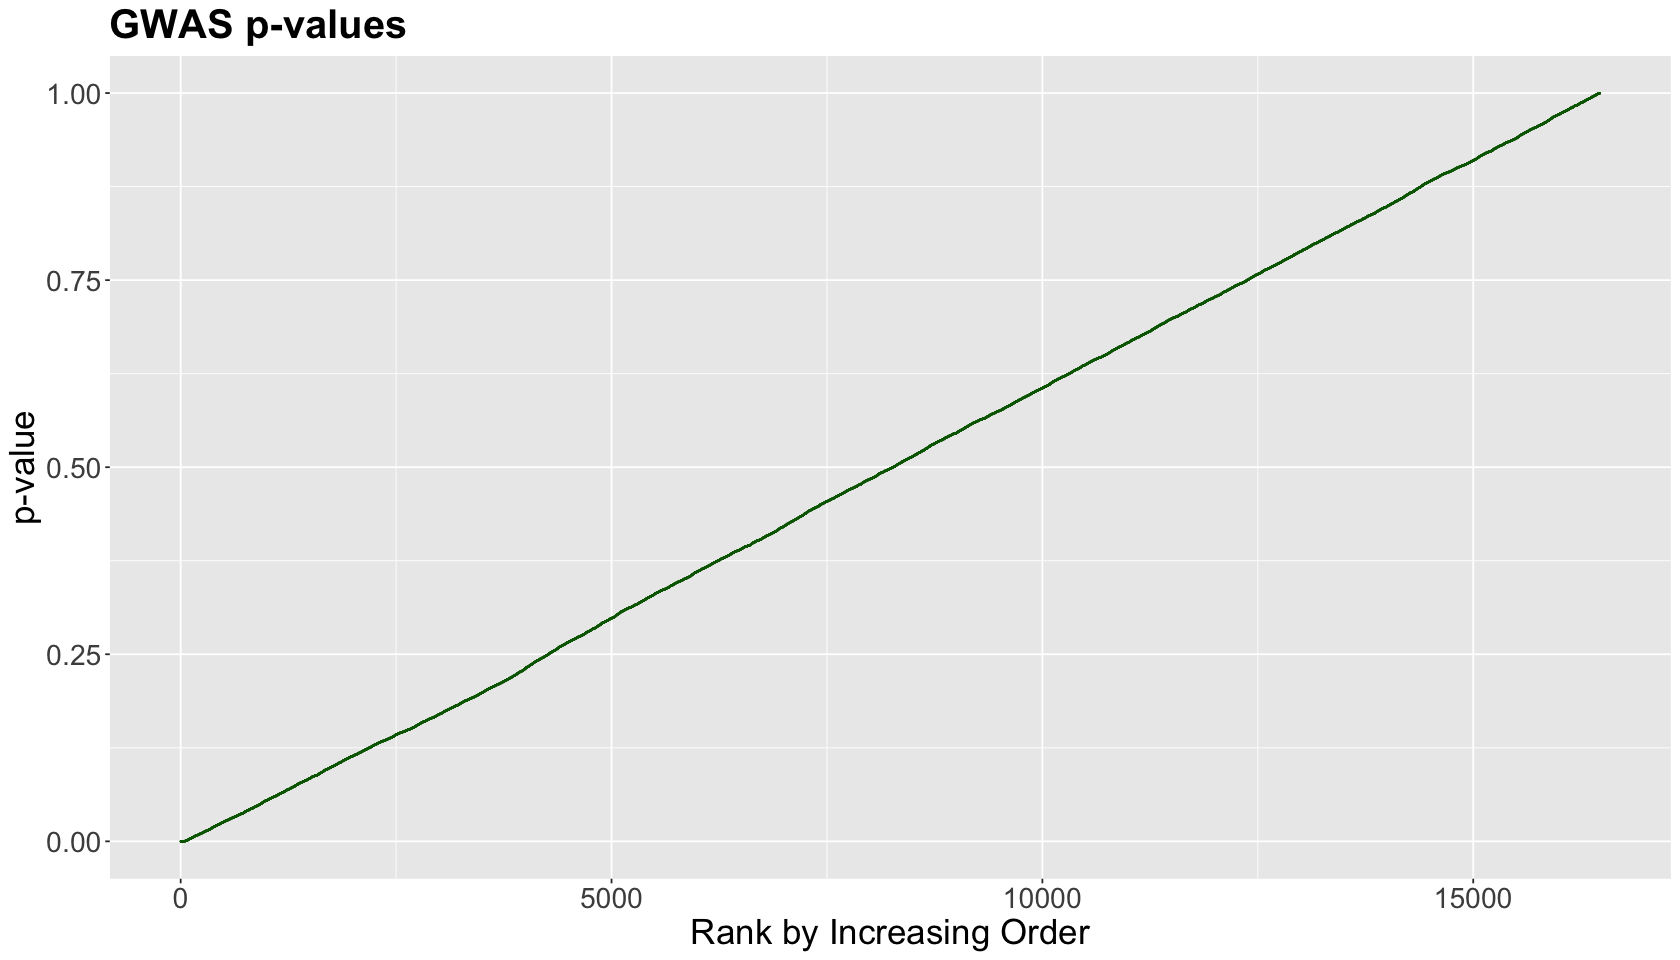

In [18]:
library(qqman)

sorted_p_values <- data.frame(p_value = gwasResults$P) %>% 
  arrange(p_value) %>%
  add_column(rank = 1:nrow(gwasResults)) %>%
  ggplot(aes(x = rank, y = p_value)) +
  geom_point(colour = "darkgreen", size = 0.01) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
  ) +
  ggtitle("GWAS p-values") +
  xlab("Rank by Increasing Order") +
  ylab("p-value")

sorted_p_values


Given the plot above, we might wonder: from this set of $p$-values, can we find a cutoff to label **significant** versus **non-significant** findings? The FDR will automate finding the “bend in the curve”.

One method to control the FDR is **Benjamini-Hochberg** (BH). Suppose you have $m$ hypothesis testings. The method has four steps:

1. Specify a **maximum tolerable FDR**, $\delta$.
2. Sort the $m$ p-values from lowest to highest (most significant to least): 

$$p_{(1)} \leq p_{(2)} \leq p_{(3)} \leq \dots \leq p_{(m)}$$

3. Let $k^*$ be the biggest $k$ for which $p_{(k)} < (\delta / m) k$
4. Take $p_{(1)}, \dots, p_{(k^*)}$ as your **significant** findings.

Let us illustrate this procedure with the following raw $p$-values:

In [19]:
raw_pvalues <- c(
  0.0010, 0.0070, 0.0110, 0.0307, 0.1096,
  0.2612, 0.4018, 0.5828, 0.7161, 0.9628
)

The previous four steps are shown in the table below. Using BH, with $\delta = 0.05$, we label $0.0010$, $0.0070$, and $0.0110$ as statistically significant via $k^* = 3$.

```{figure} ../img/table1_FDR.png
:height: 350px
:name: table1_FDR
```

We graphically show the previous BH example below, where each point represents an ordered $p$-value. Note the cutoff value is at $k^* = 3$ (vertical dashed blue line) while the red line corresponds to $(\delta / m) k$ with $\delta = 0.05$ and $m = 10$.

In [20]:
pvalues <- data.frame(raw_pvalues, k = seq_along(raw_pvalues)) %>%
  mutate(bh_line = 0.05 / nrow(.) * k)

FDR_plot <- ggplot(pvalues, aes(x = factor(k), y = raw_pvalues)) +
  geom_point() +
  geom_line(aes(x = k, y = bh_line), colour = "red") +
  xlab("k") +
  ylab("p(k)") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "none"
  ) +
  geom_vline(xintercept = 3, colour = "darkblue", linetype = "dashed") +
  ggtitle("BH Example")

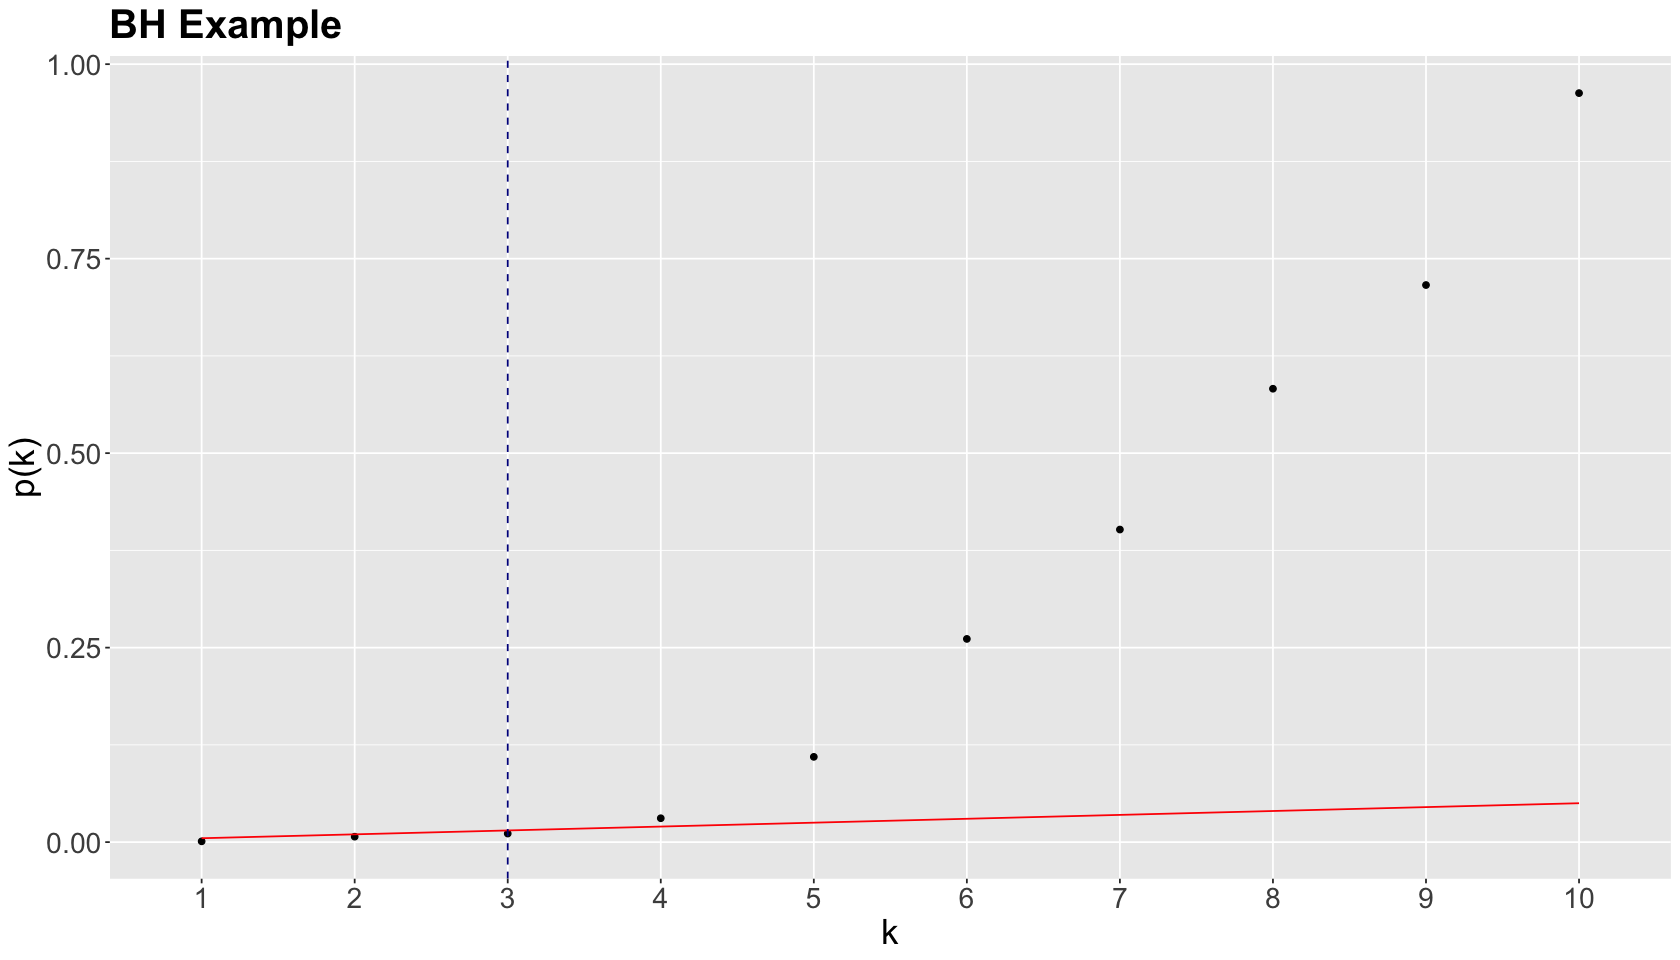

In [21]:
FDR_plot

As in the case of the Bonferroni correction, we can obtain **BH adjusted $p$-values** as

$$\text{BH adjusted } p\text{-value}_i = \min \Big\{ \frac{p\text{-value}_i \times m}{i}, \text{BH adjusted } p\text{-value}_{i + 1} \Big\},$$

where:

- $i$ is the rank of the raw $p$-value.
- $m$ is the number of tests.

```{figure} ../img/table2_FDR.png
:height: 350px
:name: table2_FDR
```

We can obtain the BH adjusted $p$-values via `p.adjust()` as we can see below.

In [22]:
round(p.adjust(raw_pvalues, method = "fdr"), 4)

[1] 0.0100 0.0350 0.0367 0.0768 0.2192 0.4353 0.5740 0.7285 0.7957 0.9628

By checking these adjusted $p$-values, using a **maximum tolerable FDR** $\delta = 0.05$, we would label the first three values (from left to right) as statistically significant.

If we want to be even less conservative, i.e. increasing $\delta$ to 0.10, we would label the first four values as statistically significant.

The table below shows different BH critical values by $\delta = 0.05, 0.10, 0.20$.

```{figure} ../img/table3_FDR.png
:height: 350px
:name: table3_FDR
```

## 6. Wrapping Up

So, **where do we stand?**

- If we must make many hypothesis testings without using some $p$-value adjustment method, then some spurious findings are expected, just by chance.
- There are more than two adjustment methods. However, from these two methods we saw, we should use them as follows:

    - **Bonferroni correction.** This method is helpful when there is high confidence all scientific findings correspond to **true positives** (i.e., we prefer to be very conservative and have **false negatives**).
    - **FDR.** This method is more appropriate if there is a certain proportion of **false positives** in our scientific findings, and we want to set up a certain level of tolerance (i.e., we prefer to be less conservative and have **false positives**).
    
|  |  **$H_0$ is true** |  **$H_0$ is not true** |
|:--------------------------------------------------------------------------------------------:|:------------------:|:----------------------:|
|                                   **Fail to reject $H_0$**                                   |       Correct (**TRUE NEGATIVE**)     |      Type II Error (**FALSE NEGATIVE**)     |
|                                       **Reject $H_0$**                                       |    Type I Error (**FALSE POSITIVE**)    |         Correct (**TRUE POSITIVE**)        |